# CW01 - GUI paper exploration 1 - Linear regression examples

We show how in the case of a very simple linear regression example zooming and the noise fast/slow divide help to recover the correct posterior.

WARNING: Only the first part of this notebook is updated to the most recent version of SWYFT. The remaining parts are left for reference and will be updated later, as they contain relevant plots for educational work.

## Imports

In [223]:
# Makes it easier to debug
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch

In [176]:
import dynesty
import swyft

In [177]:
device = 'cuda'

## Workflow: ZoomTask

In [197]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.Store.memory_store(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head)
        
    def round(self, N, train_args = {}, head = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        print(dataset[0][0]['y'].shape)
        
        network_1d = swyft.get_marginal_classifier(
            observation_key="y",
            marginal_indices=((0,), (1,), (2,), (3,)),
            observation_shapes={'y': (64,)},
            n_parameters=4,
            hidden_features=256,
            num_blocks=2,
        )

        mre_1d = swyft.MarginalRatioEstimator(
            marginal_indices=((0,), (1,), (2,), (3,)),
            network=network_1d,
            device=device,
        )
        
        mre_1d.train(dataset, batch_size = 64, max_epochs = 30)
        posterior_1d = swyft.MarginalPosterior(mre_1d, prior, bound)
        new_bound = posterior_1d.truncate(1000, self.target_obs)
        self.history.append([posterior_1d, new_bound])

## Model

In [179]:
COUNTER = 0  # Counter for number of likelihood evaluations (relevant for Dynesty)

In [180]:
N = 64  # Number of data bins
SIGMA = 1.0  # Measurement uncertainty

In [181]:
# Noise-free model

# Model and reference parameters
def spec(a, b, c, d, LW = 0.3):
    global COUNTER
    COUNTER += 1
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    y = spec(v[0], v[1], v[2], v[3])
    noise = 0*np.random.randn(N)*SIGMA
    return dict(y=y + noise)

# Noise model
def noise(sim, v, sigma = SIGMA):
    #return sim
    noise = np.random.randn(N)*sigma
    return dict(y = sim['y'] + noise)

## Step 1 - Fast slow - Wide

In [224]:
sigma_A = SIGMA/N**0.5  # Expected uncertainty

In [225]:
low = -10 * np.ones(4)
high = 20 * np.ones(4)
prior = swyft.get_uniform_prior(low, high)

In [226]:
v0 = np.array([-0.0, 0, 0, 0])
obs0 = noise(model(v0), v0)

In [227]:
sim = swyft.Simulator(model, 4, dict(y=(N,)))
#prior = swyft.Prior.from_uv(transform, 4, n_grid_points = 1000)

In [239]:
class Head(torch.nn.Module):
    def __init__(self, sim_shapes):
        super().__init__()
        self.n_features = 4
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 4)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [240]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0, 1])

Creating new store.
CPU times: user 2.94 ms, sys: 0 ns, total: 2.94 ms
Wall time: 2.87 ms


In [233]:
task.run(rounds = 3, N = 1000, train_args = dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)

Store: Adding 985 new samples to simulator store.
torch.Size([64])
training: lr=5e-07, epoch=25, validation loss=3.8079
Store: Adding 702 new samples to simulator store.
torch.Size([64])
training: lr=5e-05, epoch=25, validation loss=3.9963
Store: Adding 623 new samples to simulator store.
torch.Size([64])
training: lr=5e-06, epoch=25, validation loss=3.9251


In [234]:
post = task.history[-1][0]
samples = post.weighted_sample(10000, obs0, batch_size = 128)

In [235]:
# Estimate poster mean
v = samples.v[:,0]
w = samples.weights[(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

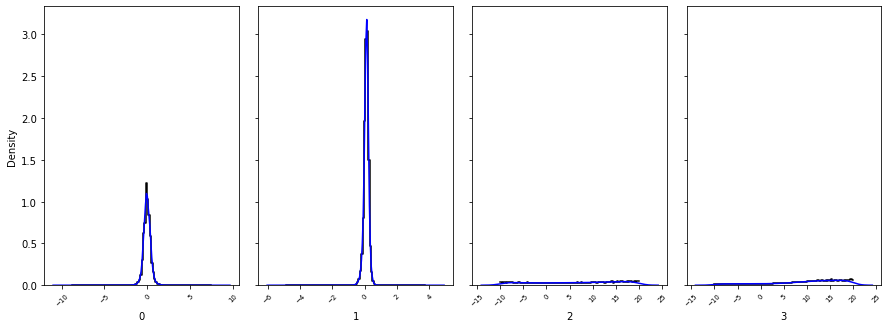

In [237]:
swyft.hist1d(samples, kde = True, figsize = (15, 5));

In [238]:
#fig, diag = swyft.plot_1d(samples, [0], bins = 100, figsize=(8, 4), truth = v0, color='r', contours = True)
#for s in [-3, -2, -1, 0, 1, 2, 3]:
#    fig.get_axes()[0].axvline(m + s*sigma_A, ls = ':')

In [222]:
h = task.history[-1][0]._ratios[((0,),(1,))].head
d = task.history[-1][0].dataset
h.cpu()

import cycler
color_cycle = cycler.cycler(color=['r', 'k', 'b', 'y', 'm', 'g'])

plt.figure(figsize = (4,4))

for i, c in zip(range(100), color_cycle()):
    s = np.array([h(d[i][0]).detach().numpy() for _ in range(30)])
    plt.scatter(s[:,0], s[:,1], marker='.', alpha = 0.1, color=c['color'])
    plt.scatter(s[0,0], s[0,1], marker='x', color=c['color'])

plt.scatter(0, 0, marker='.', color='k', label='Fast+slow')
plt.scatter(0, 0, marker='x', color='k', label='Slow only')
plt.legend(frameon = True)
    
plt.xlabel("feature 1")
plt.ylabel("feature 2")

AttributeError: 'MarginalPosterior' object has no attribute '_ratios'

## Step 1 - Fast slow - Narrow

In [555]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 2.).ppf(u[0])
    b = scipy.stats.uniform(-1., 2.).ppf(u[1])
    return np.array([a, b, 0, 0])

sigma_A = SIGMA/N**0.5  # Expected uncertainty

In [556]:
v0 = np.array([-0.0, 0, 0, 0])
obs0 = noise(model(v0), v0)

In [557]:
sim = swyft.Simulator(model, 4, dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [558]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 2
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 2)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [559]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0, 1])
task.run(rounds = 1, N = 1000, train_args = dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)

Creating new store.
Store: Adding 984 new samples to simulator store.
Training: lr=2.4e-07, Epoch=45, VL=1.666
Bounds: Truncating...
Bounds: ...done. New volue is V=0.8797
CPU times: user 5.88 s, sys: 8.84 s, total: 14.7 s
Wall time: 23.3 s


In [560]:
post = task.history[-1][0]
samples = post.sample(1000000, obs0)

In [561]:
# Estimate poster mean
v = samples['v'][:,0]
w = samples['weights'][(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

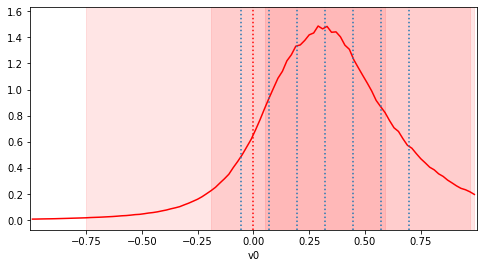

In [562]:
fig, diag = swyft.plot_1d(samples, [0], bins = 100, figsize=(8, 4), truth = v0, color='r', contours = True)
for s in [-3, -2, -1, 0, 1, 2, 3]:
    fig.get_axes()[0].axvline(m + s*sigma_A, ls = ':')

Text(0, 0.5, 'feature 2')

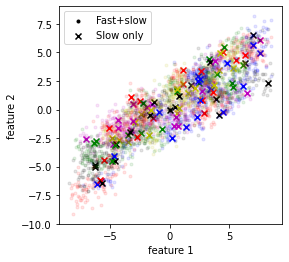

In [563]:
h = task.history[-1][0]._ratios[((0,),(1,))].head
d = task.history[-1][0].dataset
h.cpu()

import cycler
color_cycle = cycler.cycler(color=['r', 'k', 'b', 'y', 'm', 'g'])

plt.figure(figsize = (4,4))

for i, c in zip(range(100), color_cycle()):
    s = np.array([h(d[i][0]).detach().numpy() for _ in range(30)])
    plt.scatter(s[:,0], s[:,1], marker='.', alpha = 0.1, color=c['color'])
    plt.scatter(s[0,0], s[0,1], marker='x', color=c['color'])

plt.scatter(0, 0, marker='.', color='k', label='Fast+slow')
plt.scatter(0, 0, marker='x', color='k', label='Slow only')
plt.legend(frameon = True)
    
plt.xlabel("feature 1")
plt.ylabel("feature 2")

Text(0, 0.5, 'x[i]')

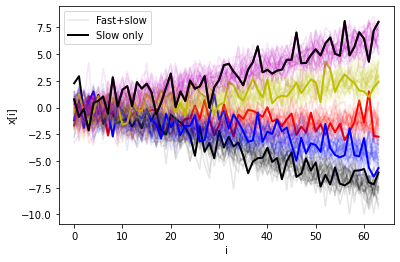

In [585]:
d = task.history[-1][0].dataset
for i, c in zip(range(5), color_cycle()):
    for _ in range(30):
        y = d[i][0]['y']
        plt.plot(y, color=c['color'], alpha = 0.1)
    plt.plot(y, color=c['color'], lw=2)

plt.plot(y, color='k', label='Fast+slow', alpha=0.1)
plt.plot(y, color='k', label='Slow only', lw=2)
plt.legend(frameon = True)
    
plt.xlabel("i")
plt.ylabel("x[i]")

## Step 1 - Anchors

In [13]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 2.).ppf(u[0])
    return np.array([a, 0, 0, 0])

sigma_A = SIGMA/N**0.5  # Expected uncertainty

In [425]:
v0 = np.array([-0.0, 0, 0, 0])
obs0 = noise(model(v0), v0)

In [426]:
sim = swyft.Simulator(model, 4, dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [427]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 1
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 1)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [428]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0])
task.run(rounds = 1, N = 10000, train_args = dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)

Creating new store.
Store: Adding 10003 new samples to simulator store.
Training: lr=3.9e-06, Epoch=23, VL=0.6479
Bounds: Truncating...
Bounds: ...done. New volue is V=0.8164
CPU times: user 25 s, sys: 6.18 s, total: 31.1 s
Wall time: 54.9 s


In [429]:
post = task.history[-1][0]
samples = post.sample(1000000, obs0)

In [430]:
# Estimate poster mean
v = samples['v'][:,0]
w = samples['weights'][(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

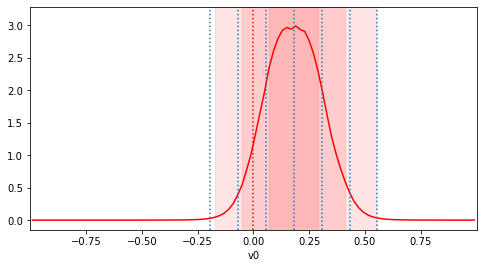

In [431]:
fig, diag = swyft.plot_1d(samples, [0], bins = 100, figsize=(8, 4), truth = v0, color='r', contours = True)
for s in [-3, -2, -1, 0, 1, 2, 3]:
    fig.get_axes()[0].axvline(m + s*sigma_A, ls = ':')

## Prior

In [97]:
def transform(u):
    a = scipy.stats.uniform(-2.5, 5).ppf(u[0])
    b = scipy.stats.uniform(-1, 2).ppf(u[1])
    c = scipy.stats.uniform(0., 10.).ppf(u[2])
    d = scipy.stats.uniform(0., 10.).ppf(u[3])
    return np.array([a, b, c, d])

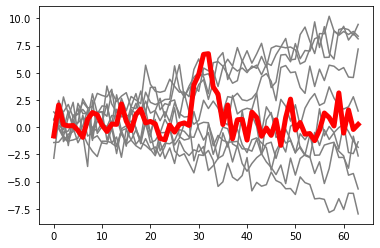

In [730]:
v0 = np.array([0, 0, 5, 5])

for _ in range(10):
    u = np.random.rand(4)
    v = transform(u)
    obs = noise(model(v), v)
    plt.plot(obs['y'], color='0.5')

obs0 = noise(model(v0), v0)
plt.plot(obs0['y'], linewidth = 5, color = 'r')

## Factorization plot

In [751]:
cov = np.eye(6)
cov[1, 0]= 0.9
cov[3, 2]= -0.7
cov[4, 3]= 0.7
cov[4, 2]= -0.5
cov[5, 4]= -0.7
mn = scipy.stats.multivariate_normal(np.zeros(6), cov)

In [752]:
v = np.random.rand(10000000, 6)*6  -3
weights = {(0, 1, 2, 3, 4, 5) : mn.pdf(v)}

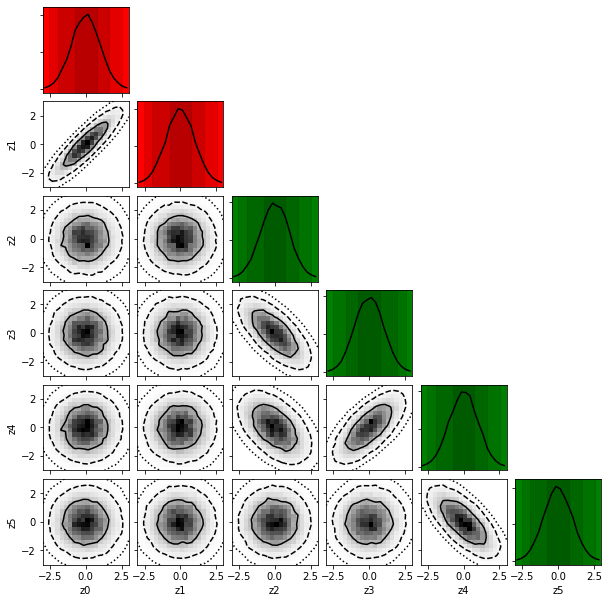

In [753]:
s = dict(v=v, weights = weights, pnames = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5'])
fig, _ = swyft.plot_corner(s, [0, 1, 2, 3, 4, 5], bins = 20)
fig.get_axes()[0].set_facecolor('r')
fig.get_axes()[7].set_facecolor('r')
fig.get_axes()[14].set_facecolor('g')
fig.get_axes()[21].set_facecolor('g')
fig.get_axes()[28].set_facecolor('g')
fig.get_axes()[35].set_facecolor('g')